
Resolved paths:
{
  "excel": "/content/UK sale retail dataset.xlsx",
  "cpi": "/content/CPI.csv",
  "unemployment": "/content/unemployment.csv",
  "awe": "/content/Avg Weekly Earning.csv",
  "gdp": "/content/Monthly GDP chained\u2011volume index.csv"
}


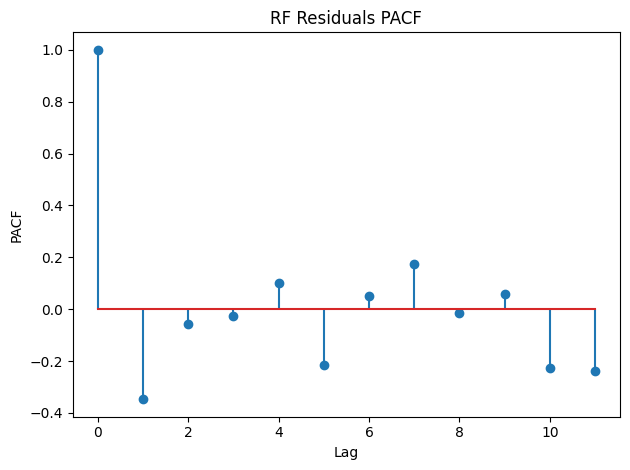

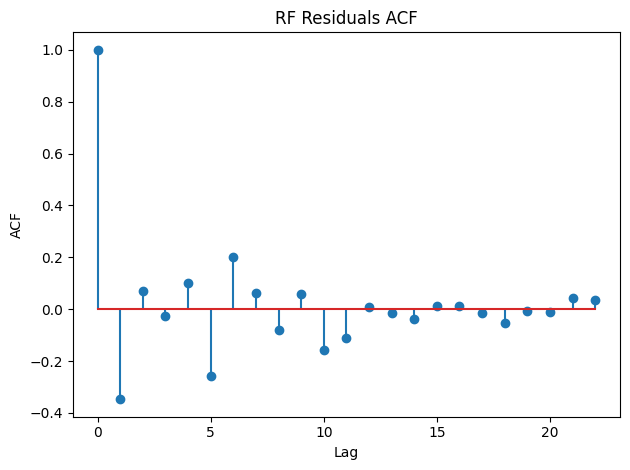

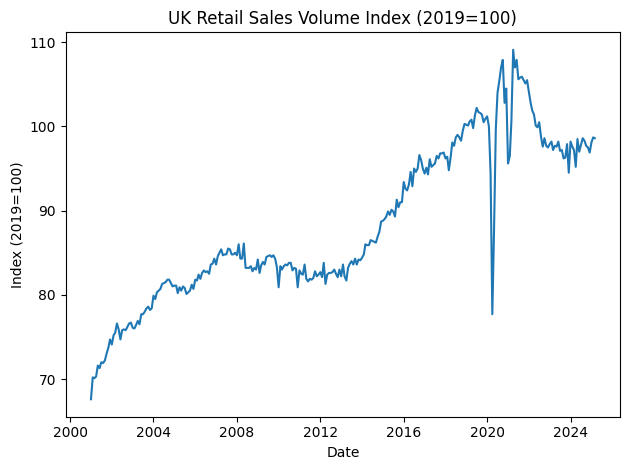

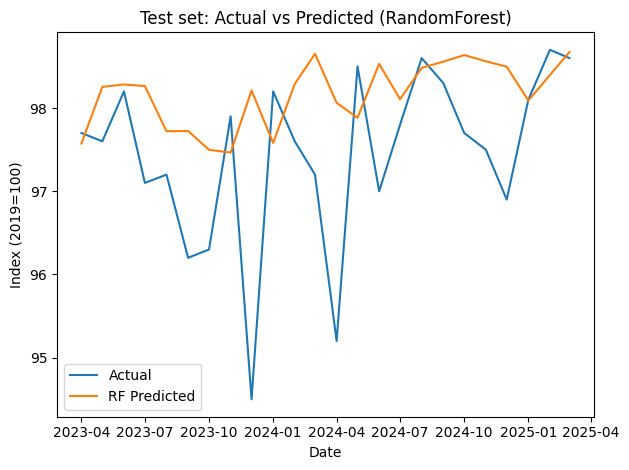

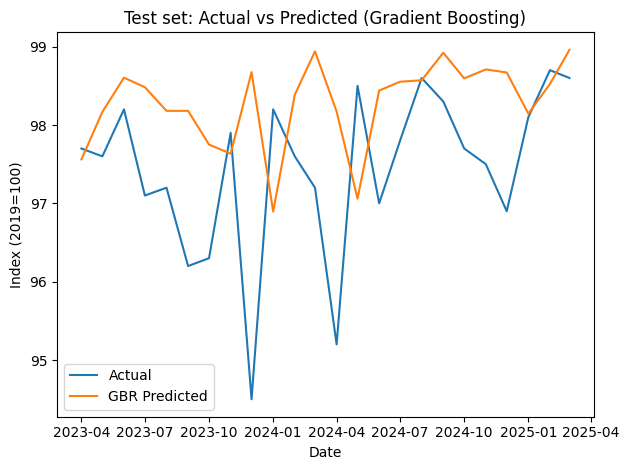

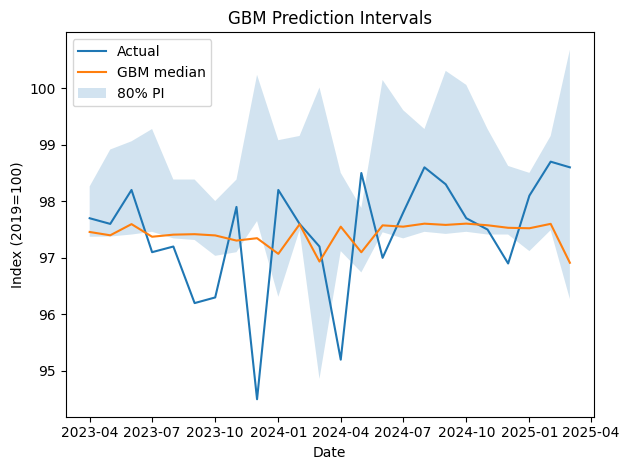

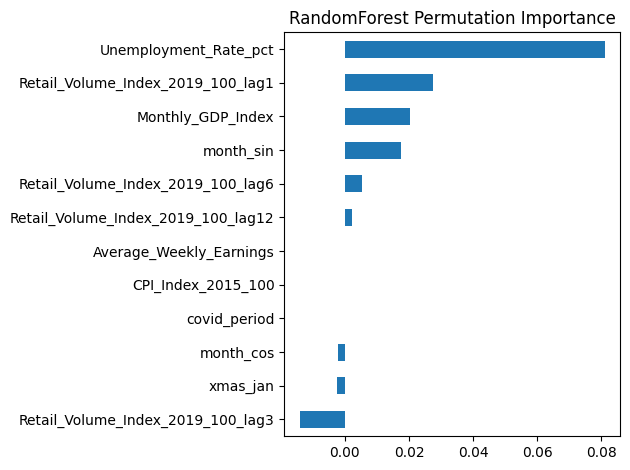


DATA SHAPES
Total rows: 291
Train rows: 267
Test  rows: 24

MODEL RESULTS – TEST SET
              Model   MAE  RMSE     R2  sMAPE                                                                             Best Params
       RandomForest 0.911 1.267 -0.512  0.935 {"max_depth": null, "min_samples_leaf": 1, "min_samples_split": 2, "n_estimators": 200}
ElasticNet (scaled) 1.623 1.864 -2.273  1.657                                                 {"en__alpha": 0.1, "en__l1_ratio": 0.8}
  GradBoost (point) 1.120 1.468 -1.031  1.149                            {"learning_rate": 0.05, "max_depth": 2, "n_estimators": 200}
  SeasonalNaive(12) 1.300 1.484 -1.361  1.338                                                                                      {}

BACKTESTS
Expanding-window (rolling origin) – first 5 windows:
 start_idx  n_test   MAE  RMSE      R2  sMAPE
       243       6 4.392 5.527 -17.802  4.208
       249       6 1.510 2.044  -1.192  1.448
       255       6 4.123 4.227 -10.980  4.

In [ ]:


# Imports
import os, re, glob, json, warnings, sys, subprocess, calendar
from typing import Dict, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Statsmodels (install if missing)
try:
    from statsmodels.tsa.stattools import acf, pacf
    from statsmodels.stats.diagnostic import acorr_ljungbox
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels", "-q"])
    from statsmodels.tsa.stattools import acf, pacf
    from statsmodels.stats.diagnostic import acorr_ljungbox

# Inline plots
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)


# Config
CONFIG = {
    "base_dir": "/content/",
    "test_horizon": 24,
    "walk_forward_start_months": 48,
    "walk_forward_step": 6,
    "random_state": 42,
    "rolling_train_window": 60,
}


# Robust path resolver
DASHES = "\u2010\u2011\u2012\u2013\u2014\u2212"

def _norm(s: str) -> str:
    s = s.lower()
    s = re.sub(f"[{DASHES}]", "-", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _score_name(fname_norm: str, keywords: List[str]) -> int:
   # simple keyword counter to "score" filenames
    return sum(1 for k in keywords if k in fname_norm)

def auto_pick_file(base_dir: str, allowed_exts, keywords: List[str], extra_globs: List[str] = None) -> str:
    extra_globs = extra_globs or []
    if not os.path.isdir(base_dir):
        raise FileNotFoundError(f"DATA_DIR does not exist: {base_dir}")
    files = [f for f in os.listdir(base_dir) if os.path.isfile(os.path.join(base_dir, f))]
    best, best_score = None, -1
    for f in files:
        if not f.lower().endswith(tuple(allowed_exts)):
            continue
        score = _score_name(_norm(f), keywords)
        if score > best_score:
            best, best_score = f, score
    if best is None:
        for pat in extra_globs or []:
            hits = glob.glob(os.path.join(base_dir, pat))
            if hits:
                best = os.path.basename(hits[0]); break
    if best is None:
        listing = "\n".join("  - "+x for x in sorted(files)[:120])
        raise FileNotFoundError(
            f"Couldn't auto-detect file in {base_dir}\n"
            f"Expected ext: {allowed_exts}; keywords: {keywords}\n"
            f"Files seen:\n{listing}"
        )
    return os.path.join(base_dir, best)


# Parsers
# converting the ONS formats into a clean monthly DataFrame
def month_str_to_datetime(s: str) -> pd.Timestamp:
    s = re.sub(r"\s+", " ", str(s).strip())
    try:
        return pd.to_datetime(s.title(), format="%Y %b")
    except Exception:
        return pd.NaT

def parse_ons_two_col_any(path: str, value_name: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv":
        df = pd.read_csv(path, header=None)
    else:
        df = pd.read_excel(path, header=None)
    mask = df[0].astype(str).str.match(r"^\d{4}\s+(JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)$", case=False)
    mdf = df.loc[mask, [0, 1]].copy()
    mdf.columns = ["DateStr", value_name]
    mdf["Date"] = mdf["DateStr"].apply(month_str_to_datetime)
    mdf.dropna(subset=["Date"], inplace=True)
    mdf.drop(columns=["DateStr"], inplace=True)
    mdf[value_name] = pd.to_numeric(mdf[value_name], errors="coerce")
    mdf.dropna(subset=[value_name], inplace=True)
    mdf = mdf.groupby("Date", as_index=False).agg({value_name: "first"}).sort_values("Date")
    return mdf

def parse_uk_retail_excel(excel_path: str) -> pd.DataFrame:
    raw = pd.read_excel(excel_path, sheet_name="Table 1 M", header=None)
    idx = raw.index[raw.iloc[:, 0].astype(str).str.contains("Index number of sales per week", na=False)]
    if len(idx) == 0:
        raise RuntimeError("Could not locate 'Index number of sales per week' header row.")
    t = pd.read_excel(excel_path, sheet_name="Table 1 M", header=idx[0])
    t.columns = t.iloc[0].tolist()
    t = t.iloc[1:].copy()
    if "Time Period" not in t.columns:
        raise RuntimeError("'Time Period' column not found.")
    candidates = [c for c in t.columns if isinstance(c, str) and "All Retailing, Including Automotive Fuel" in c]
    if not candidates:
        raise RuntimeError("Column for 'All Retailing, Including Automotive Fuel' not found.")
    col = candidates[0]
    s = t["Time Period"].astype(str).str.strip()
    mask = s.str.match(r"^\d{4}\s+(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)$", case=False)
    out = t.loc[mask, ["Time Period", col]].copy()
    out.rename(columns={"Time Period": "Date", col: "Retail_Volume_Index_2019_100"}, inplace=True)
    out["Date"] = pd.to_datetime(out["Date"].str.title(), format="%Y %b")
    out["Retail_Volume_Index_2019_100"] = pd.to_numeric(out["Retail_Volume_Index_2019_100"], errors="coerce")
    out.dropna(inplace=True)
    out = out.groupby("Date", as_index=False).agg({"Retail_Volume_Index_2019_100": "first"}).sort_values("Date")
    return out


# Features & metrics
def add_time_features(df: pd.DataFrame, date_col: str = "Date") -> pd.DataFrame:
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df["Month"] = df[date_col].dt.month
    df["month_sin"] = np.sin(2 * np.pi * df["Month"] / 12.0)
    df["month_cos"] = np.cos(2 * np.pi * df["Month"] / 12.0)
    df["xmas_jan"] = df[date_col].dt.month.isin([12, 1]).astype(int)
    df["covid_period"] = ((df[date_col] >= "2020-04-01") & (df[date_col] <= "2021-03-31")).astype(int)
    return df

# Classic time-series lags of the target
def lag_features(df: pd.DataFrame, target: str, lags=(1, 3, 6, 12)) -> pd.DataFrame:
    df = df.copy()
    for L in lags:
        df[f"{target}_lag{L}"] = df[target].shift(L)
    return df
#Regression metrics + sMAPE
def evaluate_all(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "sMAPE": smape}

def seasonal_naive(y: pd.Series, season: int = 12) -> pd.Series:
    return y.shift(season)

# expanding window backtest
def walk_forward_eval(base_model, X: pd.DataFrame, y: pd.Series, start_test_idx: int, step: int = 6) -> pd.DataFrame:
    i = start_test_idx
    rows = []
    while i < len(y):
        X_tr, y_tr = X.iloc[:i], y.iloc[:i]
        X_te, y_te = X.iloc[i:i+step], y.iloc[i:i+step]
        if len(y_te) == 0:
            break
        m = clone(base_model)
        m.fit(X_tr, y_tr)
        pred = m.predict(X_te)
        rows.append({"start_idx": i, "n_test": len(y_te), **evaluate_all(y_te, pred)})
        i += step
    return pd.DataFrame(rows)

def rolling_window_eval(base_model, X: pd.DataFrame, y: pd.Series, start_test_idx: int, step: int = 6, train_window: int = 60) -> pd.DataFrame:
    i = start_test_idx
    rows = []
    while i < len(y):
        tr_start = max(0, i - train_window)
        X_tr, y_tr = X.iloc[tr_start:i], y.iloc[tr_start:i]
        X_te, y_te = X.iloc[i:i+step], y.iloc[i:i+step]
        if len(y_te) == 0 or len(y_tr) == 0:
            break
        m = clone(base_model)
        m.fit(X_tr, y_tr)
        pred = m.predict(X_te)
        rows.append({"start_idx": i, "n_test": len(y_te), **evaluate_all(y_te, pred)})
        i += step
    return pd.DataFrame(rows)


# Main
def main():
    base = CONFIG["base_dir"]

    # Resolve files
    excel_path = auto_pick_file(base, (".xlsx", ".xls"),
                                keywords=["uk","sale","retail","dataset","table","1","m"])
    cpi_path   = auto_pick_file(base, (".csv", ".xlsx"), keywords=["cpi"])
    une_path   = auto_pick_file(base, (".csv", ".xlsx"), keywords=["unemployment","unemploy"])
    awe_path   = auto_pick_file(base, (".csv", ".xlsx"), keywords=["avg","average","weekly","earning","earnings","awe"])
    gdp_path   = auto_pick_file(base, (".csv", ".xlsx"),
                                keywords=["monthly","gdp","chained","volume","index"],
                                extra_globs=["*gdp*.csv","*gdp*.xlsx","*chained*volume*index*.csv","*chained*volume*index*.xlsx"])

    print("\nResolved paths:")
    print(json.dumps({
        "excel": excel_path, "cpi": cpi_path, "unemployment": une_path,
        "awe": awe_path, "gdp": gdp_path
    }, indent=2))

    # Load & merge
    retail = parse_uk_retail_excel(excel_path)
    cpi    = parse_ons_two_col_any(cpi_path,  "CPI_Index_2015_100")
    une    = parse_ons_two_col_any(une_path,  "Unemployment_Rate_pct")
    awe    = parse_ons_two_col_any(awe_path,  "Average_Weekly_Earnings")
    gdp    = parse_ons_two_col_any(gdp_path,  "Monthly_GDP_Index")

    df = (retail.merge(cpi, on="Date", how="left")
                 .merge(une, on="Date", how="left")
                 .merge(awe, on="Date", how="left")
                 .merge(gdp, on="Date", how="left"))
    df = df.dropna().sort_values("Date").reset_index(drop=True)
    df = add_time_features(df, "Date")

    target = "Retail_Volume_Index_2019_100"

    # Feature engineering
    df = lag_features(df, target, lags=(1, 3, 6, 12)).dropna().reset_index(drop=True)

    # Train/test
    test_horizon = CONFIG["test_horizon"]
    train = df.iloc[:-test_horizon].copy()
    test  = df.iloc[-test_horizon:].copy()

    feature_cols = [
        "CPI_Index_2015_100", "Unemployment_Rate_pct", "Average_Weekly_Earnings",
        "Monthly_GDP_Index", "month_sin", "month_cos", "xmas_jan", "covid_period",
        f"{target}_lag1", f"{target}_lag3", f"{target}_lag6", f"{target}_lag12",
    ]
    X_train, y_train = train[feature_cols], train[target]
    X_test,  y_test  = test[feature_cols],  test[target]

    # Models
    tscv = TimeSeriesSplit(n_splits=3)

    # Randomforest
    rf = RandomForestRegressor(random_state=CONFIG["random_state"])
    rf_param_grid = {"n_estimators": [200], "max_depth": [None], "min_samples_split": [2], "min_samples_leaf": [1]}
    rf_gs = GridSearchCV(rf, rf_param_grid, cv=tscv, scoring="neg_mean_squared_error", n_jobs=1)
    rf_gs.fit(X_train, y_train)
    rf_best = rf_gs.best_estimator_
    rf_pred = rf_best.predict(X_test)
    rf_metrics = evaluate_all(y_test, rf_pred)

    # ElasticNet with standardScaler
    en_pipe = Pipeline([("scaler", StandardScaler()),
                        ("en", ElasticNet(max_iter=10000, random_state=CONFIG["random_state"]))])
    en_param_grid = {"en__alpha": [0.01, 0.1, 1.0], "en__l1_ratio": [0.2, 0.5, 0.8]}
    en_gs = GridSearchCV(en_pipe, en_param_grid, cv=tscv, scoring="neg_mean_squared_error", n_jobs=1)
    en_gs.fit(X_train, y_train)
    en_best = en_gs.best_estimator_
    en_pred = en_best.predict(X_test)
    en_metrics = evaluate_all(y_test, en_pred)

    # Gradient Boosting
    gb = GradientBoostingRegressor(random_state=CONFIG["random_state"])
    gb_param_grid = {"n_estimators": [200], "learning_rate": [0.05, 0.1], "max_depth": [2, 3]}
    gb_gs = GridSearchCV(gb, gb_param_grid, cv=tscv, scoring="neg_mean_squared_error", n_jobs=1)
    gb_gs.fit(X_train, y_train)
    gb_best = gb_gs.best_estimator_
    gb_pred = gb_best.predict(X_test)
    gb_metrics = evaluate_all(y_test, gb_pred)

    # Baseline : seasonal naive
    y_pred_naive = seasonal_naive(test[target], 12).dropna()
    y_true_naive = test[target].iloc[12:]
    baseline_metrics = evaluate_all(y_true_naive, y_pred_naive)

    # Backtests : expanding vs fixed rolling window
    start_idx = len(df) - CONFIG["walk_forward_start_months"]
    wf_scores = walk_forward_eval(rf_best, df[feature_cols], df[target], start_idx, CONFIG["walk_forward_step"])
    rw_scores = rolling_window_eval(rf_best, df[feature_cols], df[target], start_idx, CONFIG["walk_forward_step"],
                                    train_window=CONFIG["rolling_train_window"])

    # Prediction intervals (quantiles)
    gbm_p10 = GradientBoostingRegressor(loss="quantile", alpha=0.10, random_state=CONFIG["random_state"]).fit(X_train, y_train)
    gbm_p50 = GradientBoostingRegressor(loss="quantile", alpha=0.50, random_state=CONFIG["random_state"]).fit(X_train, y_train)
    gbm_p90 = GradientBoostingRegressor(loss="quantile", alpha=0.90, random_state=CONFIG["random_state"]).fit(X_train, y_train)
    p10, p50, p90 = gbm_p10.predict(X_test), gbm_p50.predict(X_test), gbm_p90.predict(X_test)

    # Permutation importance
    pi = permutation_importance(rf_best, X_test, y_test, n_repeats=10, random_state=CONFIG["random_state"])
    perm_imp = pd.Series(pi.importances_mean, index=feature_cols).sort_values(ascending=False)

    # Residual diagnostics (RF)
    res_rf = y_test.values - rf_pred

    # Ljung–Box: lag ≤ len(res)-1
    max_lb_lag = max(1, min(24, len(res_rf) - 1))
    try:
        lb = acorr_ljungbox(res_rf, lags=max_lb_lag, return_df=True)
    except ValueError:
        alt_lag = max(1, min(12, len(res_rf) - 1))
        lb = acorr_ljungbox(res_rf, lags=alt_lag, return_df=True)

    # ACF / PACF: choose safe lags
    acf_nlags = max(1, min(24, len(res_rf) - 2))
    acf_vals = acf(res_rf, nlags=acf_nlags, fft=True)

    max_pacf_lag = (len(res_rf) // 2) - 1  # pacf requirement
    if max_pacf_lag >= 1:
        pacf_nlags = min(24, max_pacf_lag)
        try:
            pacf_vals = pacf(res_rf, nlags=pacf_nlags, method="ywm")
        except TypeError:
            pacf_vals = pacf(res_rf, nlags=pacf_nlags)
        plt.figure()
        markerline, stemlines, baseline = plt.stem(range(len(pacf_vals)), pacf_vals)
        plt.title("RF Residuals PACF")
        plt.xlabel("Lag"); plt.ylabel("PACF")
        plt.tight_layout(); plt.show(); plt.close()
    else:
        print("\n[Note] PACF skipped: sample too small (needs nlags < len(residuals)/2).")

    plt.figure()
    markerline, stemlines, baseline = plt.stem(range(len(acf_vals)), acf_vals)
    plt.title("RF Residuals ACF")
    plt.xlabel("Lag"); plt.ylabel("ACF")
    plt.tight_layout(); plt.show(); plt.close()

    # Error breakdowns
    eval_df = pd.DataFrame({
        "Date": test["Date"].values,
        "y_true": y_test.values,
        "rf_pred": rf_pred,
        "covid_period": test["covid_period"].values
    })
    eval_df["abs_err"] = np.abs(eval_df["rf_pred"] - eval_df["y_true"])
    eval_df["sq_err"] = (eval_df["rf_pred"] - eval_df["y_true"])**2
    eval_df["month"] = pd.to_datetime(eval_df["Date"]).dt.month

    err_by_month = eval_df.groupby("month").agg(
        MAE=("abs_err", "mean"),
        RMSE=("sq_err", lambda s: np.sqrt(np.mean(s))),
        n=("abs_err", "size")
    ).reset_index()
    err_by_month["month_name"] = err_by_month["month"].apply(lambda m: calendar.month_abbr[m])
    err_by_month = err_by_month[["month_name","MAE","RMSE","n"]].round(3)

    err_by_covid = eval_df.groupby("covid_period").agg(
        MAE=("abs_err", "mean"),
        RMSE=("sq_err", lambda s: np.sqrt(np.mean(s))),
        n=("abs_err", "size")
    ).reset_index().replace({"covid_period": {0: "Non-COVID", 1: "COVID period"}})
    err_by_covid = err_by_covid[["covid_period","MAE","RMSE","n"]].round(3)


    desc = df[[target, "CPI_Index_2015_100", "Unemployment_Rate_pct",
               "Average_Weekly_Earnings", "Monthly_GDP_Index"]].describe().T.round(2)

    dfe = df.copy()
    for col in [target, "CPI_Index_2015_100", "Average_Weekly_Earnings", "Monthly_GDP_Index"]:
        dfe[col + "_YoY"] = dfe[col].pct_change(12)
    corr = dfe[[c for c in dfe.columns if c.endswith("_YoY")] + ["Unemployment_Rate_pct"]].corr().round(3)

    # PLOTS (inline)
    plt.figure()
    plt.plot(df["Date"], df[target])
    plt.title("UK Retail Sales Volume Index (2019=100)")
    plt.xlabel("Date"); plt.ylabel("Index (2019=100)")
    plt.tight_layout(); plt.show(); plt.close()

    plt.figure()
    plt.plot(test["Date"], y_test.values, label="Actual")
    plt.plot(test["Date"], rf_pred, label="RF Predicted")
    plt.title("Test set: Actual vs Predicted (RandomForest)")
    plt.xlabel("Date"); plt.ylabel("Index (2019=100)")
    plt.legend(); plt.tight_layout(); plt.show(); plt.close()

    plt.figure()
    plt.plot(test["Date"], y_test.values, label="Actual")
    plt.plot(test["Date"], gb_pred, label="GBR Predicted")
    plt.title("Test set: Actual vs Predicted (Gradient Boosting)")
    plt.xlabel("Date"); plt.ylabel("Index (2019=100)")
    plt.legend(); plt.tight_layout(); plt.show(); plt.close()

    plt.figure()
    plt.plot(test["Date"], y_test.values, label="Actual")
    plt.plot(test["Date"], p50, label="GBM median")
    plt.fill_between(test["Date"], p10, p90, alpha=0.2, label="80% PI")
    plt.title("GBM Prediction Intervals")
    plt.xlabel("Date"); plt.ylabel("Index (2019=100)")
    plt.legend(); plt.tight_layout(); plt.show(); plt.close()

    plt.figure()
    perm_imp.iloc[::-1].plot(kind="barh")
    plt.title("RandomForest Permutation Importance")
    plt.tight_layout(); plt.show(); plt.close()

    # TEXT OUTPUTS
    print("\n" + "="*100)
    print("DATA SHAPES")
    print("="*100)
    print(f"Total rows: {len(df):,}")
    print(f"Train rows: {len(train):,}")
    print(f"Test  rows: {len(test):,}")

    print("\n" + "="*100)
    print("MODEL RESULTS – TEST SET")
    print("="*100)
    res_table = pd.DataFrame([
        {"Model":"RandomForest",       **rf_metrics, "Best Params": json.dumps(rf_gs.best_params_)},
        {"Model":"ElasticNet (scaled)",**en_metrics, "Best Params": json.dumps(en_gs.best_params_)},
        {"Model":"GradBoost (point)",  **gb_metrics, "Best Params": json.dumps(gb_gs.best_params_)},
        {"Model":"SeasonalNaive(12)",  **baseline_metrics, "Best Params": "{}"},
    ]).loc[:, ["Model","MAE","RMSE","R2","sMAPE","Best Params"]].round(3)
    print(res_table.to_string(index=False))

    print("\n" + "="*100)
    print("BACKTESTS")
    print("="*100)
    if not wf_scores.empty:
        agg_wf = wf_scores[["MAE","RMSE","R2","sMAPE"]].agg(["mean","median","min","max"]).round(3)
        print("Expanding-window (rolling origin) – first 5 windows:")
        print(wf_scores.head().round(3).to_string(index=False))
        print("\nAggregates (Expanding):")
        print(agg_wf.to_string())
    else:
        print("Expanding-window: not enough data.")

    if not rw_scores.empty:
        agg_rw = rw_scores[["MAE","RMSE","R2","sMAPE"]].agg(["mean","median","min","max"]).round(3)
        print("\nFixed-size rolling-window – first 5 windows:")
        print(rw_scores.head().round(3).to_string(index=False))
        print("\nAggregates (Rolling 60-month train):")
        print(agg_rw.to_string())
    else:
        print("Rolling-window: not enough data.")

    print("\n" + "="*100)
    print("RF RESIDUAL DIAGNOSTICS")
    print("="*100)
    print("Ljung–Box p-values (no autocorrelation if p>0.05):")
    print(lb.round(4).to_string(index=False))

    print("\n" + "="*100)
    print("ERROR BREAKDOWNS (RandomForest)")
    print("="*100)
    print("By month-of-year:")
    print(err_by_month.to_string(index=False))
    print("\nCOVID vs Non-COVID:")
    print(err_by_covid.to_string(index=False))

    print("\n" + "="*100)
    print("TOP 10 FEATURES (Permutation Importance on Test, RF)")
    print("="*100)
    print(perm_imp.head(10).round(4).to_string())

    # ElasticNet coefficients (econ interpretation)
    en_coefs = pd.Series(en_best.named_steps["en"].coef_, index=feature_cols)
    en_top = en_coefs.reindex(feature_cols).dropna()
    top_signed = en_top.reindex(en_top.abs().sort_values(ascending=False).index).head(8).round(4)

    print("\n" + "="*100)
    print("ELASTICNET COEFFICIENTS (Standardized features) – Top 8 by |coef|")
    print("="*100)
    print(top_signed.to_string())

    def sign_word(x): return "positive" if x > 0 else ("negative" if x < 0 else "near zero")
    print("\nInterpretation hints:")
    if "CPI_Index_2015_100" in en_top.index:
        print(f"  • CPI coeff is {sign_word(en_top['CPI_Index_2015_100'])} ({en_top['CPI_Index_2015_100']:.4f}).")
    if "Average_Weekly_Earnings" in en_top.index:
        print(f"  • AWE coeff is {sign_word(en_top['Average_Weekly_Earnings'])} ({en_top['Average_Weekly_Earnings']:.4f}).")
    if "Monthly_GDP_Index" in en_top.index:
        print(f"  • GDP coeff is {sign_word(en_top['Monthly_GDP_Index'])} ({en_top['Monthly_GDP_Index']:.4f}).")

    print("\n" + "="*100)
    print("DESCRIPTIVE STATISTICS (key variables)")
    print("="*100)
    print(desc.to_string())

    print("\n" + "="*100)
    print("YoY CORRELATION MATRIX (selected)")
    print("="*100)
    print(corr.to_string())

    print("\n" + "="*100)
    print("DONE.")
    print("="*100)

    return {
        "RandomForest": rf_metrics,
        "ElasticNet": en_metrics,
        "GradBoost(point)": gb_metrics,
        "SeasonalNaive(12)": baseline_metrics
    }

# Run
if __name__ == "__main__":
    summary = main()
    print(f"\nQuick recap → RF RMSE: {summary['RandomForest']['RMSE']:.3f} | "
          f"EN RMSE: {summary['ElasticNet']['RMSE']:.3f} | "
          f"GBM RMSE: {summary['GradBoost(point)']['RMSE']:.3f} | "
          f"SNaive RMSE: {summary['SeasonalNaive(12)']['RMSE']:.3f}")


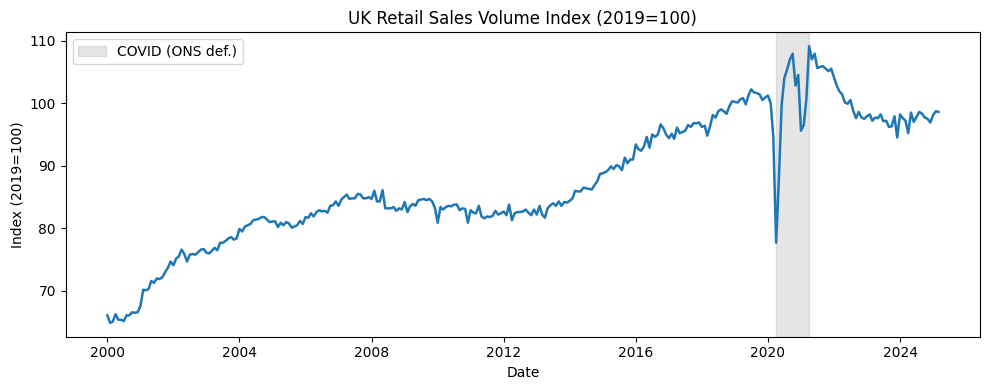

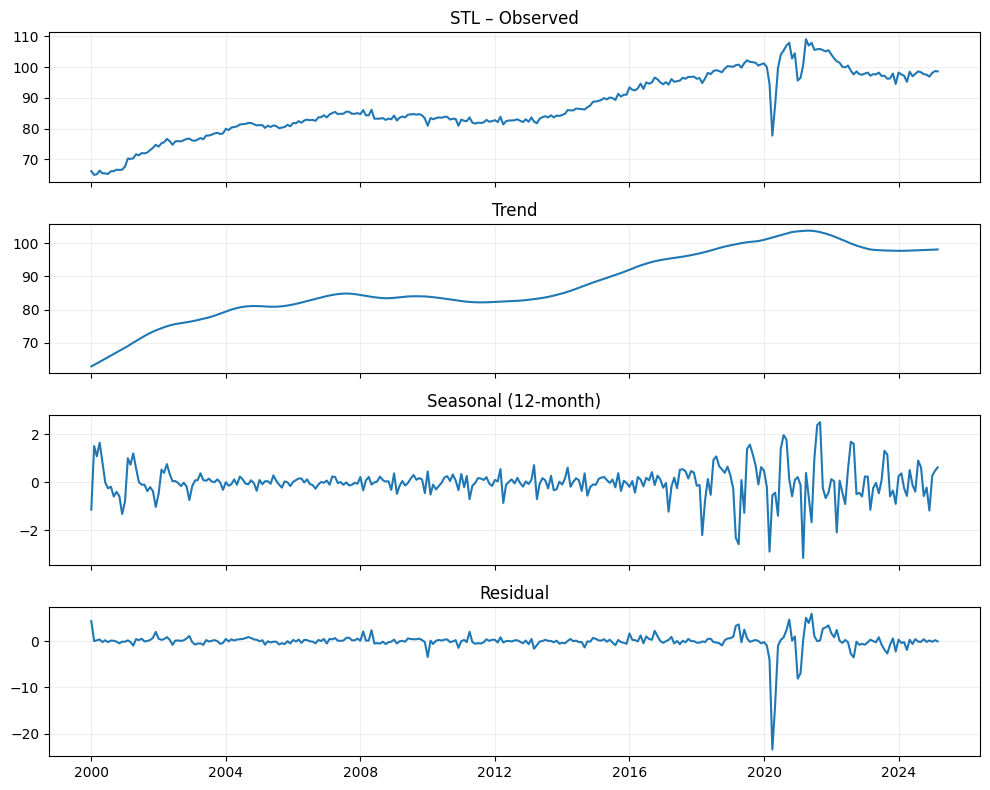

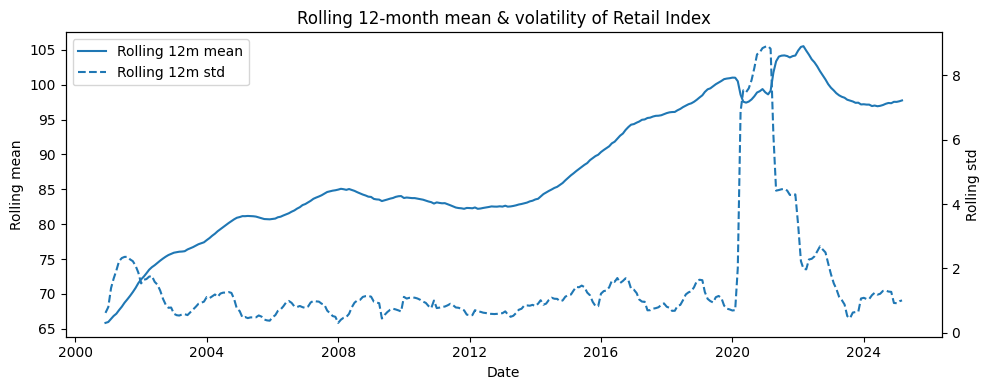

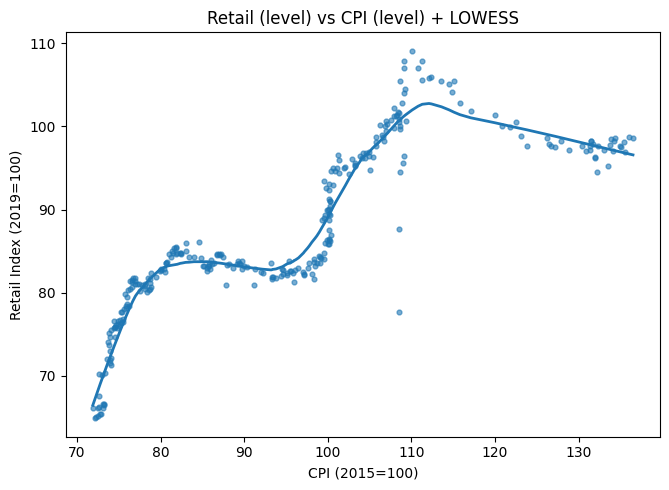

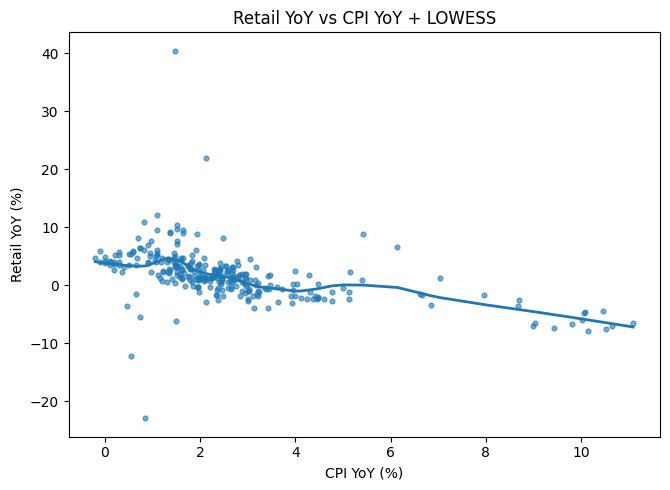

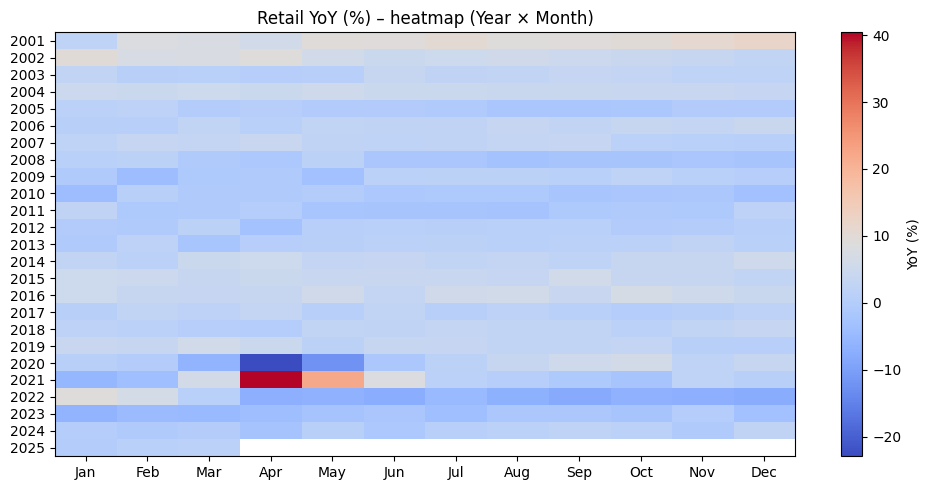

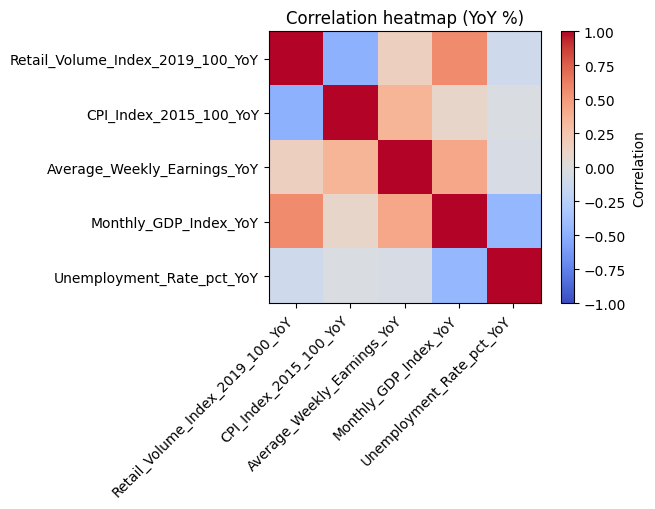

In [ ]:


import os, re, glob, warnings, calendar, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


try:
    from statsmodels.tsa.seasonal import STL
    from statsmodels.nonparametric.smoothers_lowess import lowess
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels", "-q"])
    from statsmodels.tsa.seasonal import STL
    from statsmodels.nonparametric.smoothers_lowess import lowess

warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams.update({"figure.figsize": (8, 4)})


DASHES = "\u2010\u2011\u2012\u2013\u2014\u2212"

def _norm(s: str) -> str:
    s = s.lower()
    s = re.sub(f"[{DASHES}]", "-", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _score_name(fname_norm: str, keywords) -> int:
    return sum(1 for k in keywords if k in fname_norm)

def auto_pick_file(base_dir, allowed_exts, keywords, extra_globs=None) -> str:
    extra_globs = extra_globs or []
    files = [f for f in os.listdir(base_dir) if os.path.isfile(os.path.join(base_dir, f))]
    best, best_score = None, -1
    for f in files:
        if not f.lower().endswith(tuple(allowed_exts)):
            continue
        sc = _score_name(_norm(f), keywords)
        if sc > best_score: best, best_score = f, sc
    if best is None:
        for pat in extra_globs:
            hits = glob.glob(os.path.join(base_dir, pat))
            if hits:
                best = os.path.basename(hits[0]); break
    if best is None:
        raise FileNotFoundError("Could not auto-detect file in /content. Upload your ONS files first.")
    return os.path.join(base_dir, best)

def month_str_to_datetime(s: str) -> pd.Timestamp:
    s = re.sub(r"\s+", " ", str(s).strip())
    try:
        return pd.to_datetime(s.title(), format="%Y %b")
    except Exception:
        return pd.NaT

def parse_ons_two_col_any(path: str, value_name: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    df = pd.read_csv(path, header=None) if ext == ".csv" else pd.read_excel(path, header=None)
    mask = df[0].astype(str).str.match(r"^\d{4}\s+(JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)$", case=False)
    mdf = df.loc[mask, [0, 1]].copy()
    mdf.columns = ["DateStr", value_name]
    mdf["Date"] = mdf["DateStr"].apply(month_str_to_datetime)
    mdf.dropna(subset=["Date"], inplace=True)
    mdf[value_name] = pd.to_numeric(mdf[value_name], errors="coerce")
    mdf.drop(columns=["DateStr"], inplace=True)
    mdf.dropna(subset=[value_name], inplace=True)
    return mdf.groupby("Date", as_index=False).agg({value_name: "first"}).sort_values("Date")

def parse_uk_retail_excel(excel_path: str) -> pd.DataFrame:
    raw = pd.read_excel(excel_path, sheet_name="Table 1 M", header=None)
    idx = raw.index[raw.iloc[:, 0].astype(str).str.contains("Index number of sales per week", na=False)]
    if len(idx) == 0:
        raise RuntimeError("Could not locate 'Index number of sales per week' header row in 'Table 1 M'.")
    t = pd.read_excel(excel_path, sheet_name="Table 1 M", header=idx[0])
    t.columns = t.iloc[0].tolist()
    t = t.iloc[1:].copy()
    if "Time Period" not in t.columns:
        raise RuntimeError("'Time Period' column not found in retail sheet.")
    candidates = [c for c in t.columns if isinstance(c, str) and "All Retailing, Including Automotive Fuel" in c]
    if not candidates:
        raise RuntimeError("Retail column 'All Retailing, Including Automotive Fuel' not found.")
    col = candidates[0]
    s = t["Time Period"].astype(str).str.strip()
    mask = s.str.match(r"^\d{4}\s+(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)$", case=False)
    out = t.loc[mask, ["Time Period", col]].copy()
    out.rename(columns={"Time Period":"Date", col:"Retail_Volume_Index_2019_100"}, inplace=True)
    out["Date"] = pd.to_datetime(out["Date"].str.title(), format="%Y %b")
    out["Retail_Volume_Index_2019_100"] = pd.to_numeric(out["Retail_Volume_Index_2019_100"], errors="coerce")
    out.dropna(inplace=True)
    return out.groupby("Date", as_index=False).agg({"Retail_Volume_Index_2019_100":"first"}).sort_values("Date")

def add_time_features(df: pd.DataFrame, date_col="Date"):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df["Month"] = df[date_col].dt.month
    df["Year"]  = df[date_col].dt.year
    return df


need_load = False
if "df" not in globals():
    need_load = True
else:
    required = {"Date","Retail_Volume_Index_2019_100","CPI_Index_2015_100",
                "Average_Weekly_Earnings","Monthly_GDP_Index","Unemployment_Rate_pct"}
    if not required.issubset(set(df.columns)):
        need_load = True

if need_load:
    BASE = "/content"
    excel_path = auto_pick_file(BASE, (".xlsx", ".xls"),
                                keywords=["uk","sale","retail","dataset","table","1","m"])
    cpi_path   = auto_pick_file(BASE, (".csv",".xlsx"), keywords=["cpi"])
    une_path   = auto_pick_file(BASE, (".csv",".xlsx"), keywords=["unemployment","unemploy"])
    awe_path   = auto_pick_file(BASE, (".csv",".xlsx"), keywords=["avg","average","weekly","earning","earnings","awe"])
    gdp_path   = auto_pick_file(BASE, (".csv",".xlsx"),
                                keywords=["monthly","gdp","chained","volume","index"],
                                extra_globs=["*gdp*.csv","*gdp*.xlsx","*chained*volume*index*.csv","*chained*volume*index*.xlsx"])

    retail = parse_uk_retail_excel(excel_path)
    cpi    = parse_ons_two_col_any(cpi_path,  "CPI_Index_2015_100")
    une    = parse_ons_two_col_any(une_path,  "Unemployment_Rate_pct")
    awe    = parse_ons_two_col_any(awe_path,  "Average_Weekly_Earnings")
    gdp    = parse_ons_two_col_any(gdp_path,  "Monthly_GDP_Index")

    df = (retail.merge(cpi,  on="Date", how="left")
                 .merge(une, on="Date", how="left")
                 .merge(awe, on="Date", how="left")
                 .merge(gdp, on="Date", how="left"))
    df = df.dropna().sort_values("Date").reset_index(drop=True)

df = add_time_features(df, "Date")

# Create YoY (%) columns (safe)
def add_yoy(df: pd.DataFrame, cols) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        if c in out.columns:
            out[c+"_YoY"] = out[c].pct_change(12) * 100.0
    return out

target = "Retail_Volume_Index_2019_100"
drivers = ["CPI_Index_2015_100","Average_Weekly_Earnings","Monthly_GDP_Index","Unemployment_Rate_pct"]
dfy = add_yoy(df, [target] + drivers)


# PLOT 1 — Target over time with COVID shading
plt.figure(figsize=(10,4))
plt.plot(df["Date"], df[target], lw=1.8)
# COVID: Apr-2020 to Mar-2021 (adjust if you prefer)
plt.axvspan(pd.Timestamp("2020-04-01"), pd.Timestamp("2021-03-31"), color="gray", alpha=0.2, label="COVID (ONS def.)")
plt.title("UK Retail Sales Volume Index (2019=100)")
plt.xlabel("Date"); plt.ylabel("Index (2019=100)")
plt.legend(loc="best"); plt.tight_layout(); plt.show(); plt.close()


# PLOT 2 — STL decomposition (trend/seasonal/resid)
# Fill small gaps if any (forward-fill) just for STL stability
ts = df.set_index("Date")[target].asfreq("MS").ffill()
stl = STL(ts, period=12, robust=True).fit()
fig, axes = plt.subplots(4, 1, figsize=(10,8), sharex=True)
axes[0].plot(ts);            axes[0].set_title("STL – Observed")
axes[1].plot(stl.trend);     axes[1].set_title("Trend")
axes[2].plot(stl.seasonal);  axes[2].set_title("Seasonal (12-month)")
axes[3].plot(stl.resid);     axes[3].set_title("Residual")
for ax in axes: ax.grid(alpha=0.2)
plt.tight_layout(); plt.show(); plt.close()


# PLOT 3 — Rolling 12-month mean & volatility (std)
roll_mean = ts.rolling(12).mean()
roll_std  = ts.rolling(12).std()

fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(ts.index, roll_mean, label="Rolling 12m mean")
ax1.set_ylabel("Rolling mean")
ax1.set_title("Rolling 12-month mean & volatility of Retail Index")
ax2 = ax1.twinx()
ax2.plot(ts.index, roll_std, label="Rolling 12m std", linestyle="--")
ax2.set_ylabel("Rolling std")
ax1.set_xlabel("Date")
lns = ax1.get_lines() + ax2.get_lines()
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="best")
plt.tight_layout(); plt.show(); plt.close()


# PLOT 4 — Relationship (levels): Retail vs CPI with LOWESS
def scatter_lowess(x, y, xlab, ylab, title):
    mask = np.isfinite(x) & np.isfinite(y)
    x_, y_ = x[mask], y[mask]
    plt.figure(figsize=(6.8,5))
    plt.scatter(x_, y_, s=12, alpha=0.6)
    if len(x_) > 10:
        lw = lowess(y_, x_, frac=0.3, it=0, return_sorted=True)
        plt.plot(lw[:,0], lw[:,1], lw=2)
    plt.xlabel(xlab); plt.ylabel(ylab); plt.title(title)
    plt.tight_layout(); plt.show(); plt.close()

if drivers[0] in df.columns:
    scatter_lowess(df["CPI_Index_2015_100"].values,
                   df[target].values,
                   "CPI (2015=100)",
                   "Retail Index (2019=100)",
                   "Retail (level) vs CPI (level) + LOWESS")


# PLOT 5 — Relationship (YoY): Retail YoY vs CPI YoY with LOWESS
if (target+"_YoY" in dfy.columns) and (drivers[0]+"_YoY" in dfy.columns):
    scatter_lowess(dfy[drivers[0]+"_YoY"].values,
                   dfy[target+"_YoY"].values,
                   "CPI YoY (%)",
                   "Retail YoY (%)",
                   "Retail YoY vs CPI YoY + LOWESS")


# PLOT 6 — YoY heatmap of Retail: Year (rows) × Month (cols)
dy = dfy.dropna(subset=[target+"_YoY"]).copy()
if not dy.empty:
    dy["Year"]  = pd.to_datetime(dy["Date"]).dt.year
    dy["Month"] = pd.to_datetime(dy["Date"]).dt.month
    pivot = dy.pivot_table(index="Year", columns="Month", values=target+"_YoY", aggfunc="mean")
    months = [calendar.month_abbr[m] for m in range(1,13)]
    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(pivot.values, aspect="auto", cmap="coolwarm", interpolation="nearest")
    ax.set_yticks(range(len(pivot.index))); ax.set_yticklabels(pivot.index.astype(int))
    ax.set_xticks(range(12)); ax.set_xticklabels(months, rotation=0)
    ax.set_title("Retail YoY (%) – heatmap (Year × Month)")
    cbar = plt.colorbar(im); cbar.set_label("YoY (%)")
    plt.tight_layout(); plt.show(); plt.close()


# PLOT 7 — Correlation heatmap (YoY) among key variables
corr_cols = []
for c in [target] + drivers:
    coly = c+"_YoY"
    if coly in dfy.columns:
        corr_cols.append(coly)
if len(corr_cols) >= 2:
    corr = dfy[corr_cols].dropna().corr()
    fig, ax = plt.subplots(figsize=(6.8,5.2))
    im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_xticks(range(len(corr_cols))); ax.set_xticklabels(corr_cols, rotation=45, ha="right")
    ax.set_yticks(range(len(corr_cols))); ax.set_yticklabels(corr_cols)
    ax.set_title("Correlation heatmap (YoY %)")
    cbar = plt.colorbar(im); cbar.set_label("Correlation")
    plt.tight_layout(); plt.show(); plt.close()

